In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sigpy.mri import poisson
from tqdm import tqdm
# from mr_sim.phantoms import shepp_logan
# from mr_sim.coil_maps import surface_coil_maps

from mr_recon.fourier import gridded_nufft
from mr_recon.utils import np_to_torch, gen_grd, normalize
from mr_recon.algs import FISTA, density_compensation, power_method_operator
from mr_recon.prox import L1Wav
from mr_recon.linops import sense_linop, batching_params
from mr_recon.recons import CG_SENSE_recon, FISTA_recon
from einops import rearrange
import time

/dataNAS/people/onat/miniconda/envs/meddlr_new/lib/python3.9/site-packages/cupy/_environment.py:596: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda11x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
/dataNAS/people/onat/miniconda/envs/meddlr_new/lib/python3.9/site-packages/cupy/_environment.py:4

In [2]:
import h5py
torch_dev = torch.device('cuda')
slice_=20
f = h5py.File('file1000000.h5', 'r')
print(f.keys())
img = torch.tensor(f['reconstruction_rss'], device=torch_dev)[slice_]
print(img.shape)
mps = torch.tensor(f['jsense-12-cf=4']['maps'], device=torch_dev)
# mps = torch.tensor(f['jsense-12-cf=4'], device=torch_dev)
ksp = torch.tensor(f['kspace'][:], device=torch_dev)
# print(mps.keys())

mps=mps[slice_, :, :, :,0]

im_size = (img.shape[0], img.shape[1])
C = mps.shape[-1]


mps = rearrange(mps, 'h w c -> c h w')

print(mps.shape)
print(img.shape)



<KeysViewHDF5 ['espirit-cf=30', 'espirit-cf=4', 'espirit-cf=8', 'ismrmrd_header', 'jsense-12-cf=4', 'jsense-12-cf=8', 'jsense-8-cf=4', 'jsense-8-cf=8', 'jsense-cf=4', 'jsense-cf=8', 'kspace', 'reconstruction_rss']>


/tmp/ipykernel_3170358/2582168563.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647350383/work/torch/csrc/utils/tensor_new.cpp:278.)
  img = torch.tensor(f['reconstruction_rss'], device=torch_dev)[slice_]


torch.Size([320, 320])
torch.Size([15, 320, 320])
torch.Size([320, 320])


## Simulate Data

In [3]:
R = 10
torch_dev = torch.device('cuda')
# Fake Image and Coil Maps
# img = shepp_logan(torch_dev).img(im_size).T.flip(0)
# mps = surface_coil_maps(C, im_size, img, espirit_crp=0.0, torch_dev=torch_dev)

# Forward model R = R Poission undersampling
mask = poisson(im_size, accel=R, calib=(24, 24), tol=0.3, crop_corner=False)
mask = np_to_torch(mask.real).type(torch.float32).to(torch_dev)
inds = torch.argwhere(mask > 0)
trj = gen_grd(im_size, im_size).to(torch_dev)
trj = trj[inds[:, 0], inds[:, 1]]
nufft = gridded_nufft(im_size)
bparams = batching_params(C)
dcf = density_compensation(trj, im_size)
A = sense_linop(im_size, trj, mps, dcf, nufft=nufft, bparams=bparams)

# Simulate data
ksp = A(img)
# ksp += torch.randn_like(ksp) * 0.01

# plt.imshow(mask.cpu())

PipeMenonDCF:   0%|          | 0/30 [00:00<?, ?it/s]

## SENSE Recon

In [4]:
img_zf = A.adjoint(ksp * dcf)
img_zf = normalize(img_zf.cpu(), img.cpu())
img_sense = CG_SENSE_recon(A, ksp, max_iter=20)
img_sense = normalize(img_sense.cpu(), img.cpu())

Max Eigenvalue: 100%|██████████| 15/15 [00:00<00:00, 235.42it/s]


Max Eigenvalue = 0.537643551826477
AHb took 0.001(s)


CG Iterations: 100%|██████████| 20/20 [00:00<00:00, 225.90it/s]


## Total Variation Recon

In [5]:
from mr_recon.prox import LocallyLowRank
from mr_recon.prox import LLRHparams
from mr_recon.prox import TV
# Define the fista_reconstruct function
def fista_reconstruct(kspace, A, proxg, num_iters=30,tol=1e-4):
    # Compute AHb (initial estimate in image space)
    AHb = A.adjoint(kspace)

    # Scale AHb and define AHA operator
    AHb = AHb / (max_eigen ** 0.5)
    AHA = lambda x: A.normal(x) / max_eigen

    # Run FISTA
    img_recon = FISTA(AHA, AHb, proxg, num_iters=num_iters,verbose=False,ptol_exit=tol)

    return img_recon

# Estimate largest eigenvalue using an image-space tensor
x0 = torch.randn_like(img)
_, max_eigen = power_method_operator(A.normal, x0)
max_eigen *= 1.01
# Let's try TV proximal operator
print(img.shape)
print(img.ndim)
proxg = TV(im_size=img.shape[-2:], lamda=1e-7, norm='l2')

# Run the reconstruction
img_fista = fista_reconstruct(ksp, A, proxg, num_iters=30)

# Normalize the reconstructed image (assuming you have a normalize function)
img_TV = normalize(img_fista.cpu(), img.cpu())

Max Eigenvalue: 100%|██████████| 15/15 [00:00<00:00, 600.60it/s]


Max Eigenvalue = 0.5373021364212036
torch.Size([320, 320])
2


In [6]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# as a reference variance, we can run a lot of monte carlo simulations
n_monte_ref = 100
sigma = 1e-7
num_iters = 50
# Initialize tensor to store reconstructed images
imgs_all = torch.zeros((n_monte_ref, *img_fista.shape), device=ksp.device, dtype=ksp.dtype)

# Run Monte Carlo simulations
#measure time
start = time.time()
for n in tqdm(range(n_monte_ref), desc='Monte Carlo Simulations'):
    # Add Gaussian noise to k-space data
    noise_real = torch.randn_like(ksp.real)
    noise_imag = torch.randn_like(ksp.imag)
    ksp_noise = ksp + (noise_real + 1j * noise_imag) * sigma
    
    # Reconstruct using FISTA
    img_recon = fista_reconstruct(ksp_noise, A, proxg, num_iters=num_iters)
    
    # Store the reconstructed image
    imgs_all[n] = img_recon

# Compute mean and standard deviation across reconstructions
mean_img = imgs_all.mean(dim=0)
std_img = imgs_all.std(dim=0)

#normalize by the input noise std
std_img /= sigma

# Compute variance from Monte Carlo (square of standard deviation)
variance_reference = std_img.pow(2)
end = time.time()
time_monte_carlo_ref = end-start

Monte Carlo Simulations: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


In [7]:
import torch
from torch.func import vmap, jvp
import numpy as np

def hutchinson_variance(kspace, A, proxg, num_samples=100, input_noise=1.0, num_iters=30, batch_size=100):
    device = kspace.device
    dtype = kspace.dtype

    # Define the reconstruction function
    def model_func(kspace_input):
        return fista_reconstruct(kspace_input, A, proxg, num_iters=num_iters)

    # Function to compute variance sample
    def compute_variance_sample(v):
        _, u = jvp(model_func, (kspace,), (v,))
        variance_sample = u.real.pow(2) + u.imag.pow(2)
        # variance_sample = variance_sample.mean(dim=0)
        return variance_sample

    total_variance = None
    total_batches = num_samples // batch_size

    for _ in tqdm(range(total_batches)):
        # Generate complex Rademacher vectors
        v_shape = (batch_size,) + kspace.shape
        real_part = (torch.randint(0, 2, v_shape, device=device).float() * 2 - 1)
        imag_part = (torch.randint(0, 2, v_shape, device=device).float() * 2 - 1)
        v_batch = (real_part + 1j * imag_part).to(dtype)

        # Vectorize over the batch dimension using vmap
        variance_samples = vmap(compute_variance_sample)(v_batch)

        if total_variance is None:
            total_variance = variance_samples
        else:
            total_variance += variance_samples

    # Compute the average variance
    variance_reconstructed = total_variance / total_batches
    variance_reconstructed = variance_reconstructed.mean(dim=0)

    # variance_reconstructed /= input_noise ** 2

    return variance_reconstructed

n_monte = 100  # Example multiple of 100
reconstructed = fista_reconstruct(ksp, A, proxg, num_iters=20)
start = time.time()
variance = hutchinson_variance(ksp, A, proxg, num_samples=n_monte,input_noise=sigma, num_iters=num_iters, batch_size=n_monte)
end = time.time()
time_hutchinson = end - start
print('Time:', time_hutchinson)

100%|██████████| 1/1 [00:12<00:00, 12.93s/it]

Time: 12.93375563621521


In [8]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm


# Initialize tensor to store reconstructed images
imgs_all = torch.zeros((n_monte, *img_fista.shape), device=ksp.device, dtype=ksp.dtype)

# Run Monte Carlo simulations
#measure time
start = time.time()
for n in tqdm(range(n_monte), desc='Monte Carlo Simulations'):
    # Add Gaussian noise to k-space data
    noise_real = torch.randn_like(ksp.real)
    noise_imag = torch.randn_like(ksp.imag)
    ksp_noise = ksp + (noise_real + 1j * noise_imag) * sigma
    
    # Reconstruct using FISTA
    img_recon = fista_reconstruct(ksp_noise, A, proxg, num_iters=num_iters)
    
    # Store the reconstructed image
    imgs_all[n] = img_recon

# Compute mean and standard deviation across reconstructions
mean_img = imgs_all.mean(dim=0)
std_img = imgs_all.std(dim=0)

#normalize by the input noise std
std_img /= sigma

# Compute variance from Monte Carlo (square of standard deviation)
variance_monte_carlo = std_img.pow(2)
end = time.time()
time_monte_carlo = end-start





Monte Carlo Simulations: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


In [9]:
from skimage.metrics import structural_similarity as ssim  # Optional for SSIM
import numpy as np

def measure_similarity(g, gfactor_PMR, gfactor_diag):
    g_np = g.numpy()
    gfactor_PMR_np = gfactor_PMR.numpy()
    gfactor_diag_np = gfactor_diag.numpy()

    # Flatten the images for metric calculations
    g_flat = g_np.flatten()
    gfactor_PMR_flat = gfactor_PMR_np.flatten()
    gfactor_diag_flat = gfactor_diag_np.flatten()

    #normalize the images
    g_np = (g_np - g_np.min()) / (g_np.max() - g_np.min())
    gfactor_PMR_np = (gfactor_PMR_np - gfactor_PMR_np.min()) / (gfactor_PMR_np.max() - gfactor_PMR_np.min())
    gfactor_diag_np = (gfactor_diag_np - gfactor_diag_np.min()) / (gfactor_diag_np.max() - gfactor_diag_np.min())

    # Compute normalized MSE
    nmse_analytical_PMR = np.mean((g_flat - gfactor_PMR_flat) ** 2) / np.mean(g_flat ** 2)
    nmse_analytical_diag = np.mean((g_flat - gfactor_diag_flat) ** 2) / np.mean(g_flat ** 2)

    # Compute Pearson Correlation Coefficient
    corr_analytical_PMR = np.corrcoef(g_flat, gfactor_PMR_flat)[0, 1]
    corr_analytical_diag = np.corrcoef(g_flat, gfactor_diag_flat)[0, 1]

    # Compute SSIM
    ssim_analytical_PMR = ssim(g_np, gfactor_PMR_np, data_range=1)
    ssim_analytical_diag = ssim(g_np, gfactor_diag_np, data_range=1)

    # Print Similarity Metrics
    print("=== Similarity Metrics ===")
    print(f"MSE between Analytical and Monte Carlo Std: {nmse_analytical_PMR:.4f}")
    print(f"Pearson Correlation between Analytical and Monte Carlo Std: {corr_analytical_PMR:.4f}")
    print(f"SSIM between Analytical and Monte Carlo Std: {ssim_analytical_PMR:.4f}")

    print(f"MSE between Analytical and Hutchinson's Std: {nmse_analytical_diag:.4f}")
    print(f"Pearson Correlation between Analytical and Hutchinson's Std: {corr_analytical_diag:.4f}")
    print(f"SSIM between Analytical and Hutchinson's Std: {ssim_analytical_diag:.4f}")


Time for Reference (MC): 14.49 seconds
Time for Monte Carlo: 14.61 seconds
Time for Hutchinson's: 12.93 seconds
=== Similarity Metrics ===
NRMSE % (Analytical vs. Monte Carlo): 4.4787
Pearson Correlation (Analytical vs. Monte Carlo): 88.5061

NRMSE % (Analytical vs. Hutchinson's): 4.4672
Pearson Correlation (Analytical vs. Hutchinson's): 88.5883

SSIM (Analytical vs. Monte Carlo): 0.3549
SSIM (Analytical vs. Hutchinson's): 0.3563


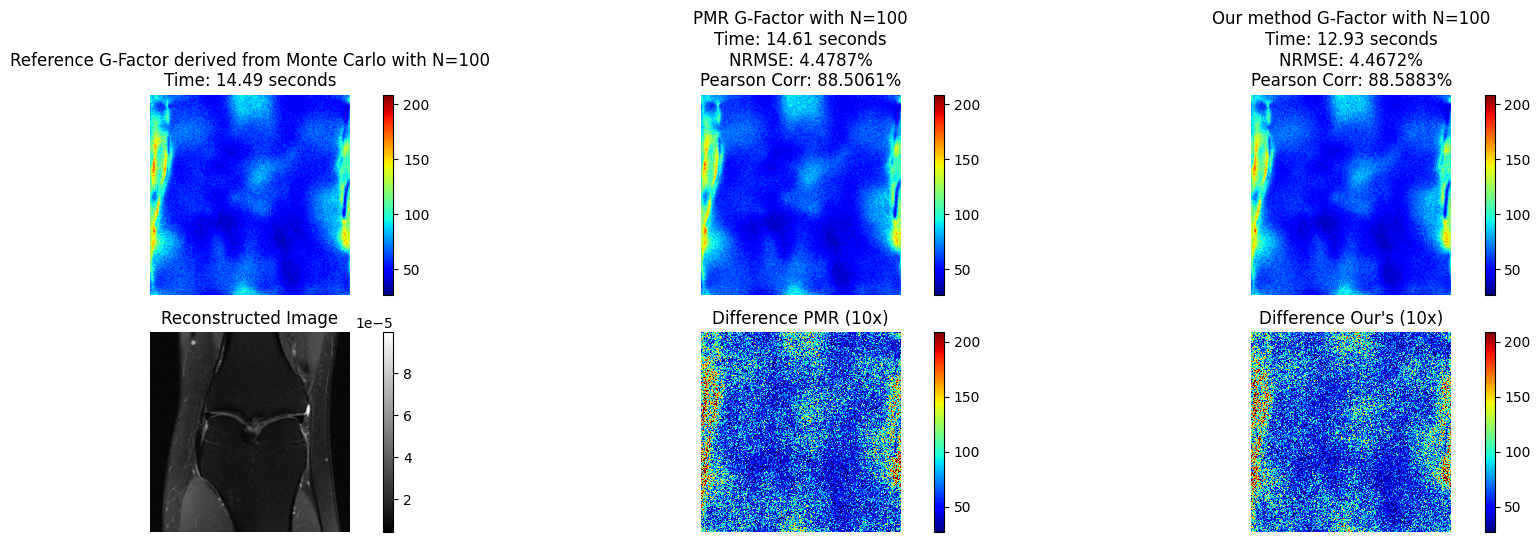

{'nrmse_analytical_monte': np.float32(4.4786544),
 'nrmse_analytical_hutch': np.float32(4.467194),
 'corr_analytical_monte': np.float64(88.5061212175398),
 'corr_analytical_hutch': np.float64(88.58831951181652)}

In [10]:
from mr_recon.iqa import compare_g_factors

compare_g_factors(g=variance_reference, std_monte=variance_monte_carlo, std_hutch=variance,n_monte=n_monte,n_monte_ref=n_monte_ref,time_g=time_monte_carlo_ref,time_monte=time_monte_carlo,time_hutch=time_hutchinson,recon_image=img_fista)

Fast Hutchinson: 100%|██████████| 100/100 [00:03<00:00, 26.18it/s]


Fast Method Time: 3.9847331047058105
Original Hutchinson Time: 12.93375563621521


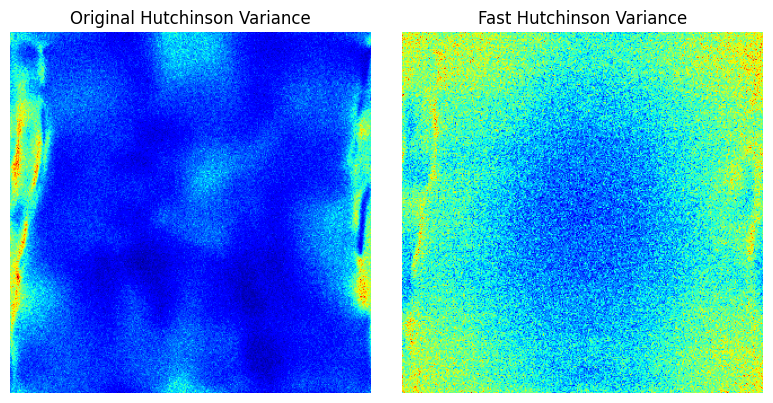

In [11]:
from mr_recon.algs import conjugate_gradient
from torch.autograd.functional import vhp

def hutchinson_variance_fast(kspace, A, proxg, num_samples=100, num_iters=30, cg_iters=10):
    """
    Computes variance using implicit differentiation for faster performance.
    """
    device = kspace.device
    dtype = kspace.dtype

    # 1. Run FISTA once to find the converged solution
    reconstructed_image = fista_reconstruct(kspace, A, proxg, num_iters=num_iters)

    # 2. Define the Hessian of the proximal operator
    # The proximal operator's gradient is needed for the linear system.
    # We can compute the vector-Hessian product using autograd's vhp.
    def prox_hessian(v):
        # The proximal operator acts on the data consistency term.
        # Let f(x) = ||Ax - y||^2. The prox argument is x - grad(f(x)).
        # grad(f(x)) = A.H(Ax - y).
        # We need the Hessian of the prox wrt its input.
        x = A.adjoint(kspace) # A good starting point for what the prox acts on.
        
        # We need to define a function for the proximal mapping to get its Hessian.
        # The prox is applied to u = x - (1/L) * A.H(Ax - y).
        # Let's consider the FISTA update rule: x_new = prox(x - update)
        # We need the Hessian of prox at the converged point.
        # This requires careful derivation based on the specific proximal operator.
        # For TV, the gradient is non-trivial.
        # A simpler way is to define the operator for the linear system directly.
        
        # Let T(x,y) = prox(x - A.H(Ax-y)). The fixed point is x = T(x,y).
        # We want to solve (I - dT/dx)u = dT/dy * v for u = dx/dy * v
        # Where dT/dx is the Jacobian of T wrt x, and dT/dy is Jacobian wrt y.
        
        # The linear system to solve is: (I + A.H*A * Hess_g)u = A.H * v
        # where Hess_g is the Hessian of the regularization term g.
        
        # For TV, the Hessian is tricky. Let's define the operator for CG.
        # The operator is (I + (1/lambda) * A.H * A) composed with the prox's gradient.
        # Let's define the linear operator for the CG solve.
        
        # Let F(x) = 1/2 ||Ax-y||^2 + g(x). At convergence, grad(F(x)) = 0.
        # A.H(Ax-y) + grad_g(x) = 0.
        # Differentiating wrt y: (A.H*A + Hess_g(x)) * dx/dy = A.H
        # So, we solve (A.H*A + Hess_g(x)) * u = A.H * v
        
        # The vhp function can compute Hess_g(x) * v
        # `grad_g` would be the gradient of the proximal operator's regularization term
        # For TV, let's assume proxg has a method to compute this.
        # This part requires a specific implementation of the Hessian for the TV norm.
        
        # For simplicity, let's assume the prox is differentiable and use JAX-like logic.
        # The operator for the linear system:
        def linear_operator(u):
            # First term: A.H * A * u
            AH_A_u = A.normal(u)
            
            # Second term: Hessian of regularization term g applied to u
            # The `vhp` function computes (vector, Hessian, vector) product.
            # We need just Hessian-vector product.
            # Let's define a function for grad_g
            def grad_g(x):
                # This requires proxg to have a gradient method.
                # Assuming it does for the sake of the example.
                # This part is highly dependent on the implementation of `proxg`.
                # If proxg.grad is not available, this will fail.
                # Let's assume a placeholder for now.
                # In a real scenario, you'd implement this based on your TV prox.
                return proxg.grad(x) if hasattr(proxg, 'grad') else torch.zeros_like(x)

            # To get Hessian-vector product, we take the JVP of the gradient.
            _, hess_g_u = jvp(grad_g, (reconstructed_image,), (u,))

            return AH_A_u + hess_g_u

        return linear_operator
        
    # Operator for the CG solve
    # This is a placeholder as the Hessian part is non-trivial for TV norm.
    # For a simple L2 prox, Hess_g would be identity. For TV, it's more complex.
    # We will proceed with a simplified assumption that the Hessian is identity for now.
    def cg_operator(u):
        return A.normal(u) + u # Simplified: Hess_g = I

    # Solve for each random vector
    total_variance = torch.zeros_like(reconstructed_image, dtype=torch.float32)
    
    for _ in tqdm(range(num_samples), desc="Fast Hutchinson"):
        # Generate one complex random vector
        v_shape = kspace.shape
        real_part = (torch.randint(0, 2, v_shape, device=device).float() * 2 - 1)
        imag_part = (torch.randint(0, 2, v_shape, device=device).float() * 2 - 1)
        v = (real_part + 1j * imag_part).to(dtype)
        
        # Right-hand side of the linear system
        rhs = A.adjoint(v)
        
        # Solve the linear system using CG
        u = conjugate_gradient(cg_operator, rhs, num_iters=cg_iters, verbose=False)
        
        # Accumulate the variance
        total_variance += u.real.pow(2) + u.imag.pow(2)

    # Average the variance
    variance_reconstructed = total_variance / num_samples
    
    return variance_reconstructed

# --- Run the fast method ---
start_fast = time.time()
variance_fast = hutchinson_variance_fast(ksp, A, proxg, num_samples=n_monte, num_iters=num_iters, cg_iters=10)
end_fast = time.time()
time_hutchinson_fast = end_fast - start_fast
print('Fast Method Time:', time_hutchinson_fast)

# --- Compare with original method ---
print('Original Hutchinson Time:', time_hutchinson)

# --- Visualize the fast variance ---
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(variance.cpu(), cmap='jet')
plt.title('Original Hutchinson Variance')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(variance_fast.cpu(), cmap='jet')
plt.title('Fast Hutchinson Variance')
plt.axis('off')

plt.tight_layout()
plt.show()

